## Stochastic Heat Equation with Spectral Solver

This notebook shows how to implement the spectral solver and how to solve the heat equation (with and without noise) using the Euler method. 

#### Load initial states

First, we setup the environment and load the initial states. The initial states are generated using the code in the `data/gaussian_random_fields.ipynb`.

In [3]:
import os
import h5py

import sys

sys.path.append(os.path.join(os.path.abspath(''), 'github', 'smdp', 'heat-diffusion'))

from dataloader import DataLoader

DATA_ROOT = os.path.join(os.path.abspath(''), 'github', 'smdp', 'heat-diffusion', 'data', 'files')

dataset_name = '32/2d_gaussian_random_field_4'

params = {'file': f'{DATA_ROOT}/{dataset_name}.h5', 'batch_size': 32}

with h5py.File(params['file'], 'r') as f:
    train_keys = list(f.keys())
    train_keys = list(zip([params['file']] * len(train_keys), train_keys))
    
train_generator = DataLoader([params['file']], train_keys, params['batch_size'], name='train', shuffle=False)

data = train_generator.__getitem__(0)[0, :, :, 0]

Length: 2500


#### Visualize initial states    

/tmp/ipykernel_94870/1086971931.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, cax=cbar_ax)


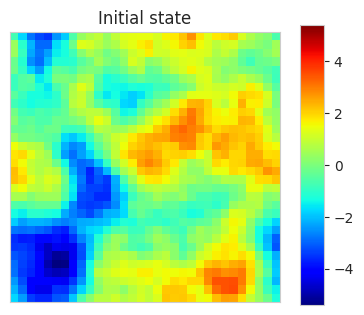

In [4]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

vmin = data.min()
vmax = data.max()
vmin = min(vmin, -vmax)
vmax = max(vmax, -vmin)

im = ax.imshow(data, cmap='jet', vmin=vmin, vmax=vmax) 
ax.set_title(f'Initial state')

ax.set_xticks([])
ax.set_yticks([])

# add colorbar 
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.06, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

### Spectral solver definition

Next, we define the spectral solver. The solver is implemented using the `jax` library. 
We use fft to transform the field to the frequency domain, apply the scaling factor, and then transform back to the spatial domain.

In [5]:
import jax.numpy as jnp
import jax
import numpy as np

def heat_diffusion(initial_value, t1):
    """
    Solves the heat equation using the spectral method. 
    :param initial_value: state at t=0
    :param t1: simulation end time
    :return: 
    """
   
    field_fft = jnp.fft.fft2(jnp.array(initial_value))
    field_shiftfft = jnp.fft.fftshift(field_fft)
    field_shiftfft = jnp.array(field_shiftfft)

    map_ = np.zeros(shape=field_fft.shape)
    for i in range(field_fft.shape[0]):
        for j in range(field_fft.shape[1]):
            map_[i,j] = jnp.sqrt((i - field_fft.shape[0] / 2) ** 2 + (j - field_fft.shape[1] / 2) ** 2)

    map_ = jnp.array(map_)

    square_map = -jnp.square(map_)
    scale_factor = jnp.exp(square_map * t1)
    
    field_shiftfft = field_shiftfft * scale_factor
    
    return jnp.real(jnp.fft.ifft2(jnp.fft.ifftshift(field_shiftfft)))

Call the solver to solve the heat equation for a given time.

In [6]:
t1 = 0.2
data_t1_direct = heat_diffusion(data, t1) 

/tmp/ipykernel_94870/312093810.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, cax=cbar_ax)


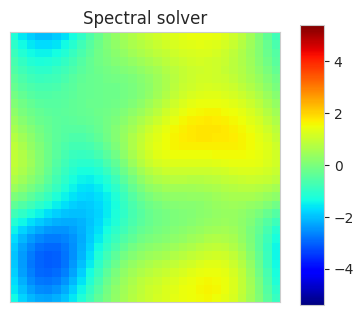

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.set_xticks([])
ax.set_yticks([])

im = ax.imshow(data_t1_direct, cmap='jet', vmin=vmin, vmax=vmax) 
ax.set_title(f'Spectral solver')

# add colorbar 
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.06, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

#### Including noise and solving the heat equation with the Euler-Maruyama method and `diffrax`. 

To include the noise term and solve the SDE, we use the `diffrax` library.

In [8]:
import jax.random as jrandom
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, WeaklyDiagonalControlTerm
import jax.numpy as jnp
from tqdm import tqdm

def stochastic_heat_diffusion(initial_value, dt0=0.01, t1=2.0, noise_scaling = 0.1):
 
    t0 = 0

    initial_shape = initial_value.shape

    diffusion = lambda t, y, args: noise_scaling * jnp.ones(initial_shape)

    map_ = np.zeros(shape=initial_shape)
    for i in range(initial_shape[0]):
        for j in range(initial_shape[1]):
            map_[i,j] = jnp.sqrt((i - initial_shape[0] / 2) ** 2 + (j - initial_shape[1] / 2) ** 2)

    map_ = jnp.array(map_)

    square_map = -jnp.square(map_)
    scale_factor = jnp.exp(square_map * dt0)
    
    y0 = initial_value

    def drift(t, y, args):
        
        field_fft = jnp.fft.fft2(jnp.array(y))
        field_shiftfft = jnp.fft.fftshift(field_fft)
        field_shiftfft = jnp.array(field_shiftfft)

        field_updated = scale_factor * field_shiftfft
        field_difference = field_updated - field_shiftfft

        drift = jnp.real(jnp.fft.ifft2(jnp.fft.ifftshift(field_difference)))
        
        return drift / dt0

    args = None

    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=initial_shape, key=jrandom.PRNGKey(0))
    terms = MultiTerm(ODETerm(drift), WeaklyDiagonalControlTerm(diffusion, brownian_motion))

    solver = Euler()
    saveat = SaveAt(dense=True)
    sol = diffeqsolve(terms, solver, t0, t1, dt0=dt0, y0=y0, saveat=saveat)
    return sol

/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/custom_types.py:133: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(0))
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/solver/runge_kutta.py:116: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  term_structure = jax.tree_structure(0)
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/solver/euler.py:25: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  term_structure = jax.tree_structure(0)
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/solver/euler_heun.py:23: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_

First, we solve the heat equation with the Euler method and set the noise to zero. This should be the same as the direct solution. 
Then we include the noise term and set the noise scaling to 0.1.

In [10]:
dt = 0.01
noise_scaling = 0.1

data_t1_euler = stochastic_heat_diffusion(data, dt0=0.01, t1=t1, noise_scaling=0.0)
data_t1_euler_noise = stochastic_heat_diffusion(data, dt0=0.01, t1=t1, noise_scaling=noise_scaling)

/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/integrate.py:617: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  term_leaves, term_structure = jax.tree_flatten(
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/heuristics.py:21: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, _ = jax.tree_flatten(terms, is_leaf=is_brownian)
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/heuristics.py:27: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, _ = jax.tree_flatten(terms, is_leaf=is_brownian)
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/misc/omega.py:81: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Us

Finally, we visualize all three solutions.

/tmp/ipykernel_94870/2600180121.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, cax=cbar_ax)


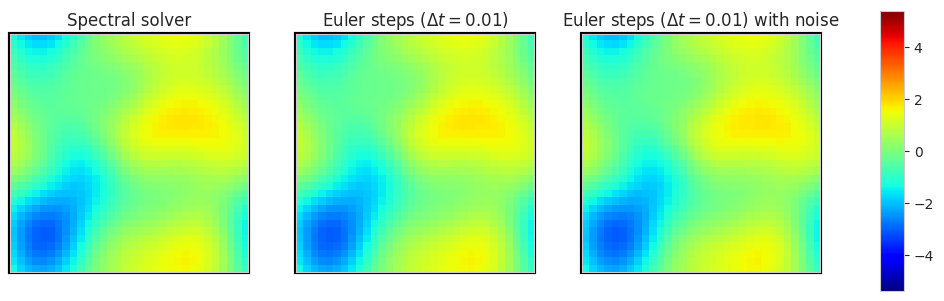

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(data_t1_direct, cmap='jet', vmin=vmin, vmax=vmax)
axs[0].set_title('Spectral solver')

axs[1].imshow(data_t1_euler.evaluate(t1), cmap='jet', vmin=vmin, vmax=vmax)
axs[1].set_title(f'Euler steps ($\Delta t = {dt}$)')

im = axs[2].imshow(data_t1_euler_noise.evaluate(t1), cmap='jet', vmin=vmin, vmax=vmax)
axs[2].set_title(f'Euler steps ($\Delta t = {dt}$) with noise')

for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].patch.set_edgecolor('black')  
    axs[i].patch.set_linewidth(3) 

# add colorbar 
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
  
plt.show()